## 1\. Data Profilling

### 1.1\. Dimensionality

In [1]:
import pandas as pd
from matplotlib.pyplot import figure, tight_layout, show
from dslabs_functions import *

file_tag = "TrafficTwoMonth"
filename = "datasets/TrafficTwoMonth_clean.csv"
target = "Total"
index = "datetime"

data: DataFrame = read_csv(
    filename,
    index_col=index,
    parse_dates=True,
    infer_datetime_format=True,
)
series: Series = data[target]


<Figure size 600x450 with 0 Axes>

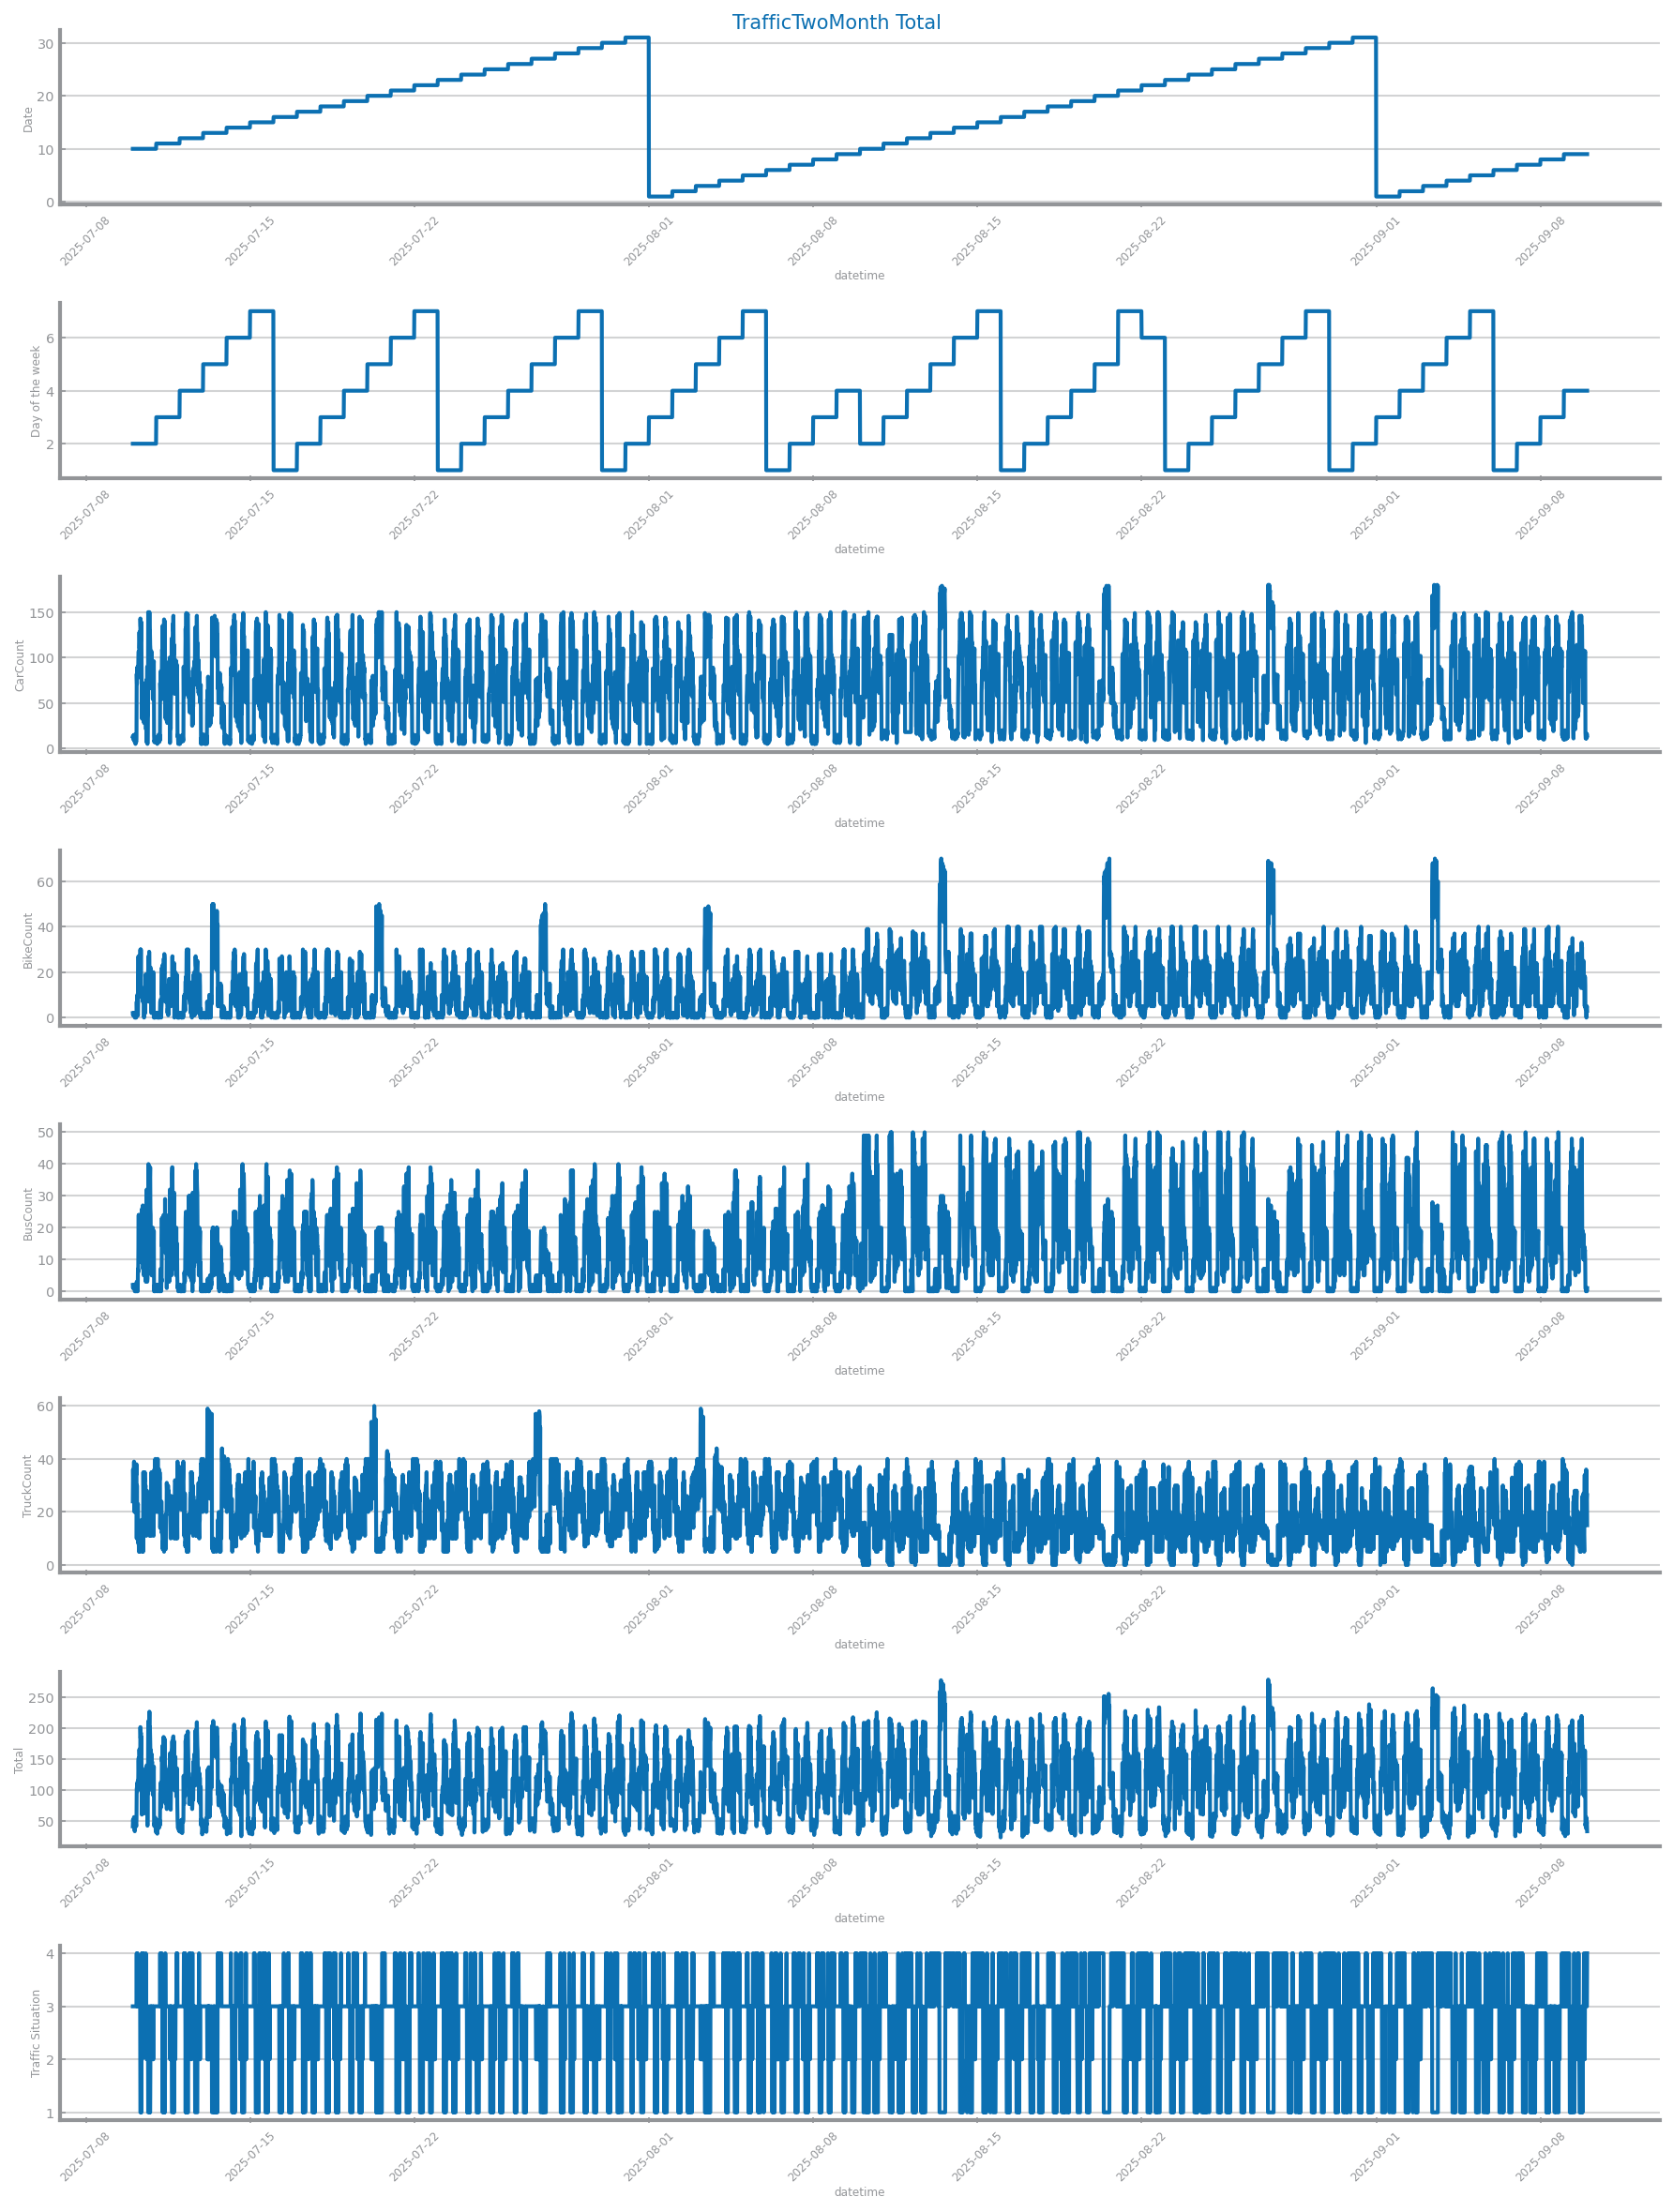

In [2]:
figure()
plot_ts_multivariate_chart(data, title=f"{file_tag} {target}")
tight_layout() 
show()

### 1.2\. Granularity

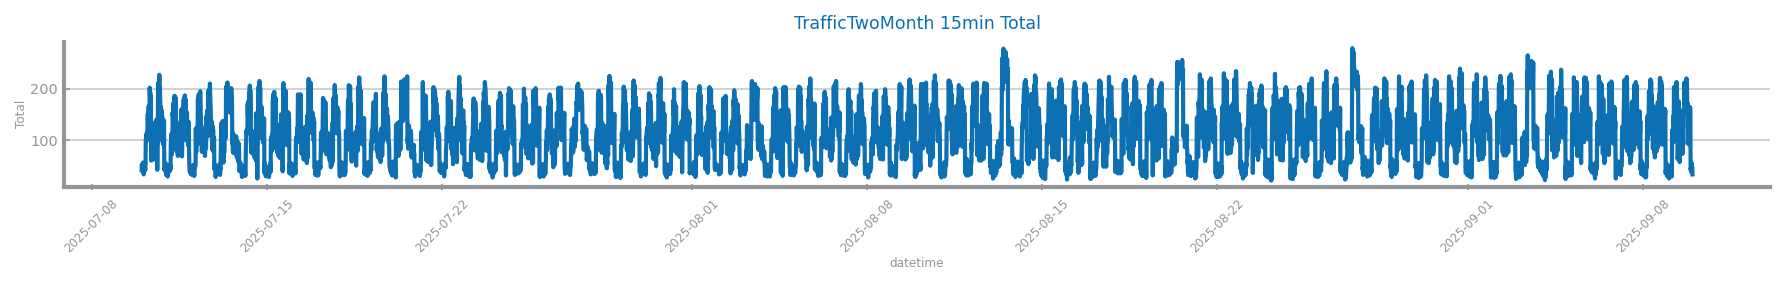

In [3]:
figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} 15min {target}",
)
tight_layout()
show()

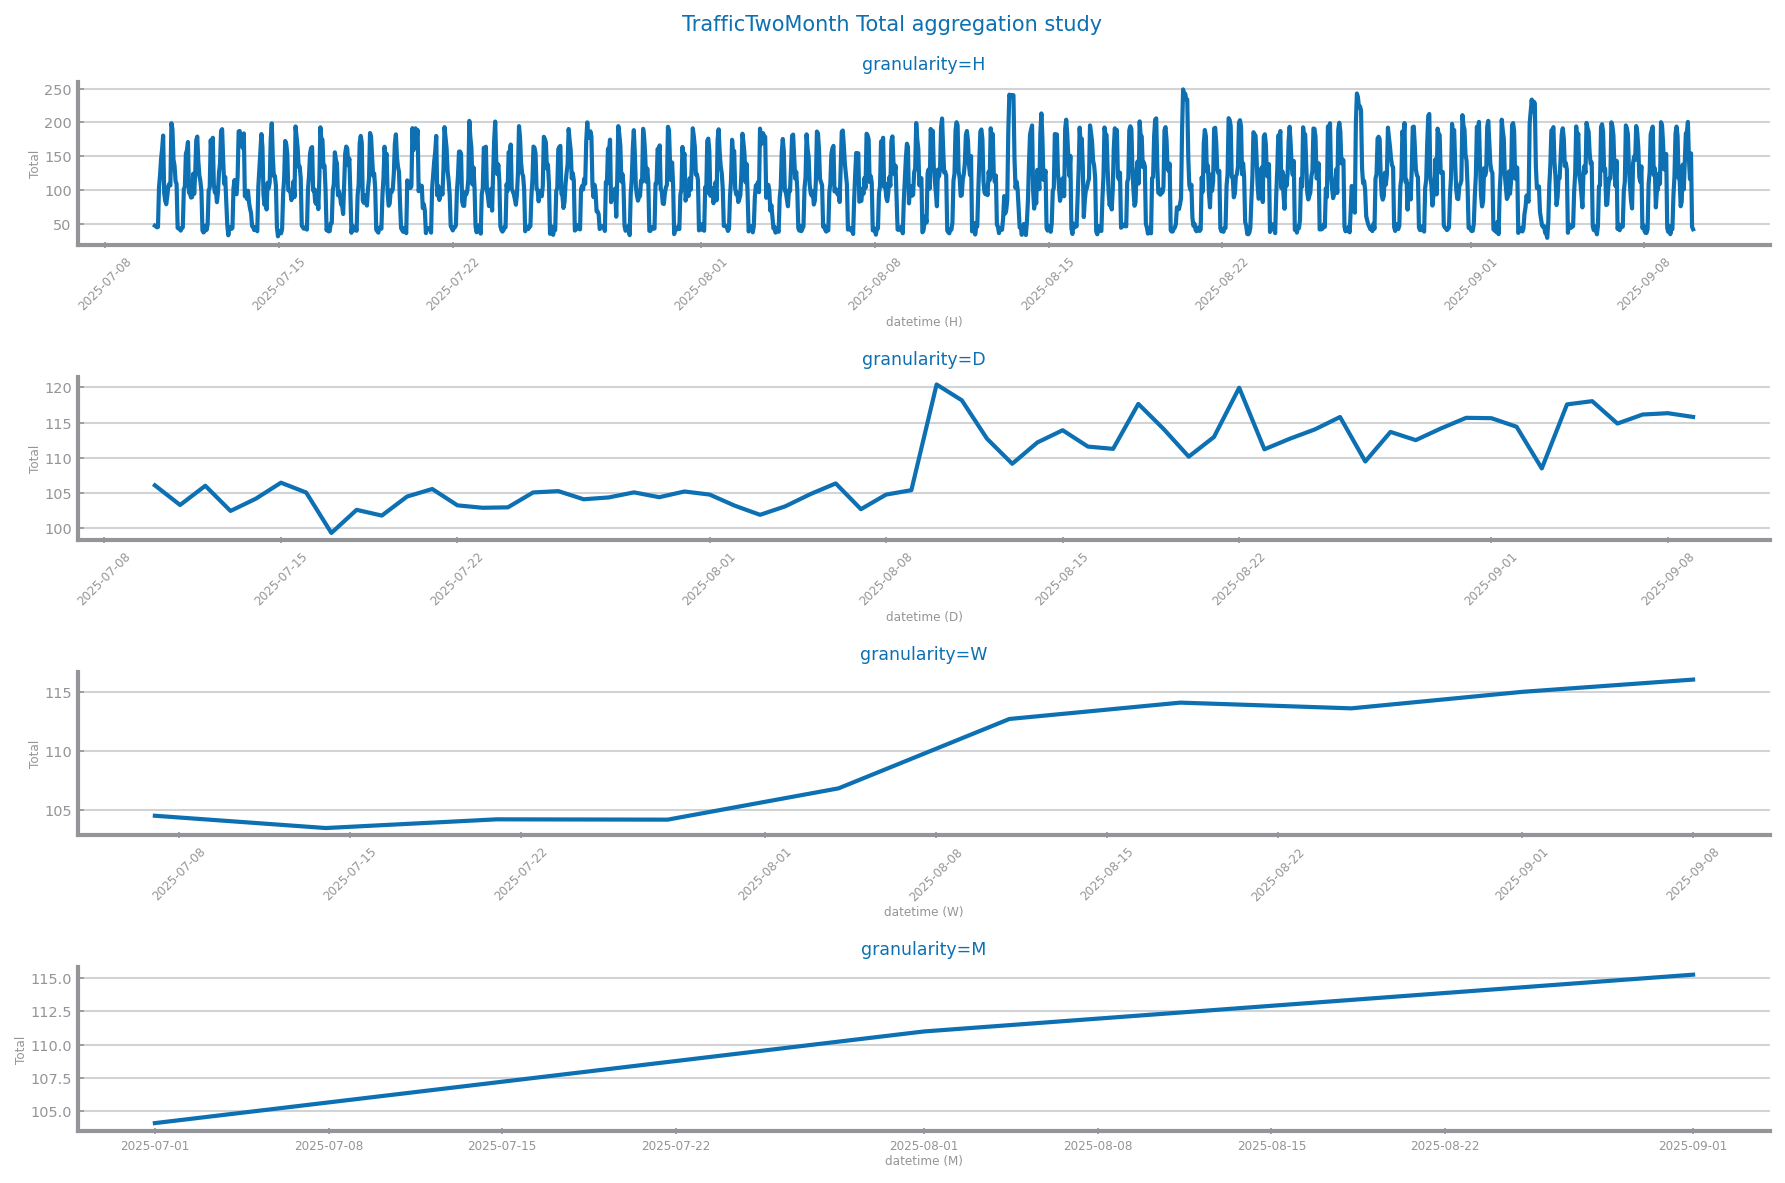

In [4]:
from matplotlib.pyplot import subplots
from matplotlib.axes import Axes
from matplotlib.figure import Figure


grans: list[str] = ["H", "D", "W", "M"]
fig: Figure
axs: list[Axes]
fig, axs = subplots(len(grans), 1, figsize=(3 * HEIGHT, HEIGHT / 2 * len(grans)))
fig.suptitle(f"{file_tag} {target} aggregation study")

for i in range(len(grans)):
    ss: Series = ts_aggregation_by(series, grans[i])
    plot_line_chart(
        ss.index.to_list(),
        ss.to_list(),
        ax=axs[i],
        xlabel=f"{ss.index.name} ({grans[i]})",
        ylabel=target,
        title=f"granularity={grans[i]}",
    )
tight_layout()
show()

### 1.3\. Distribution

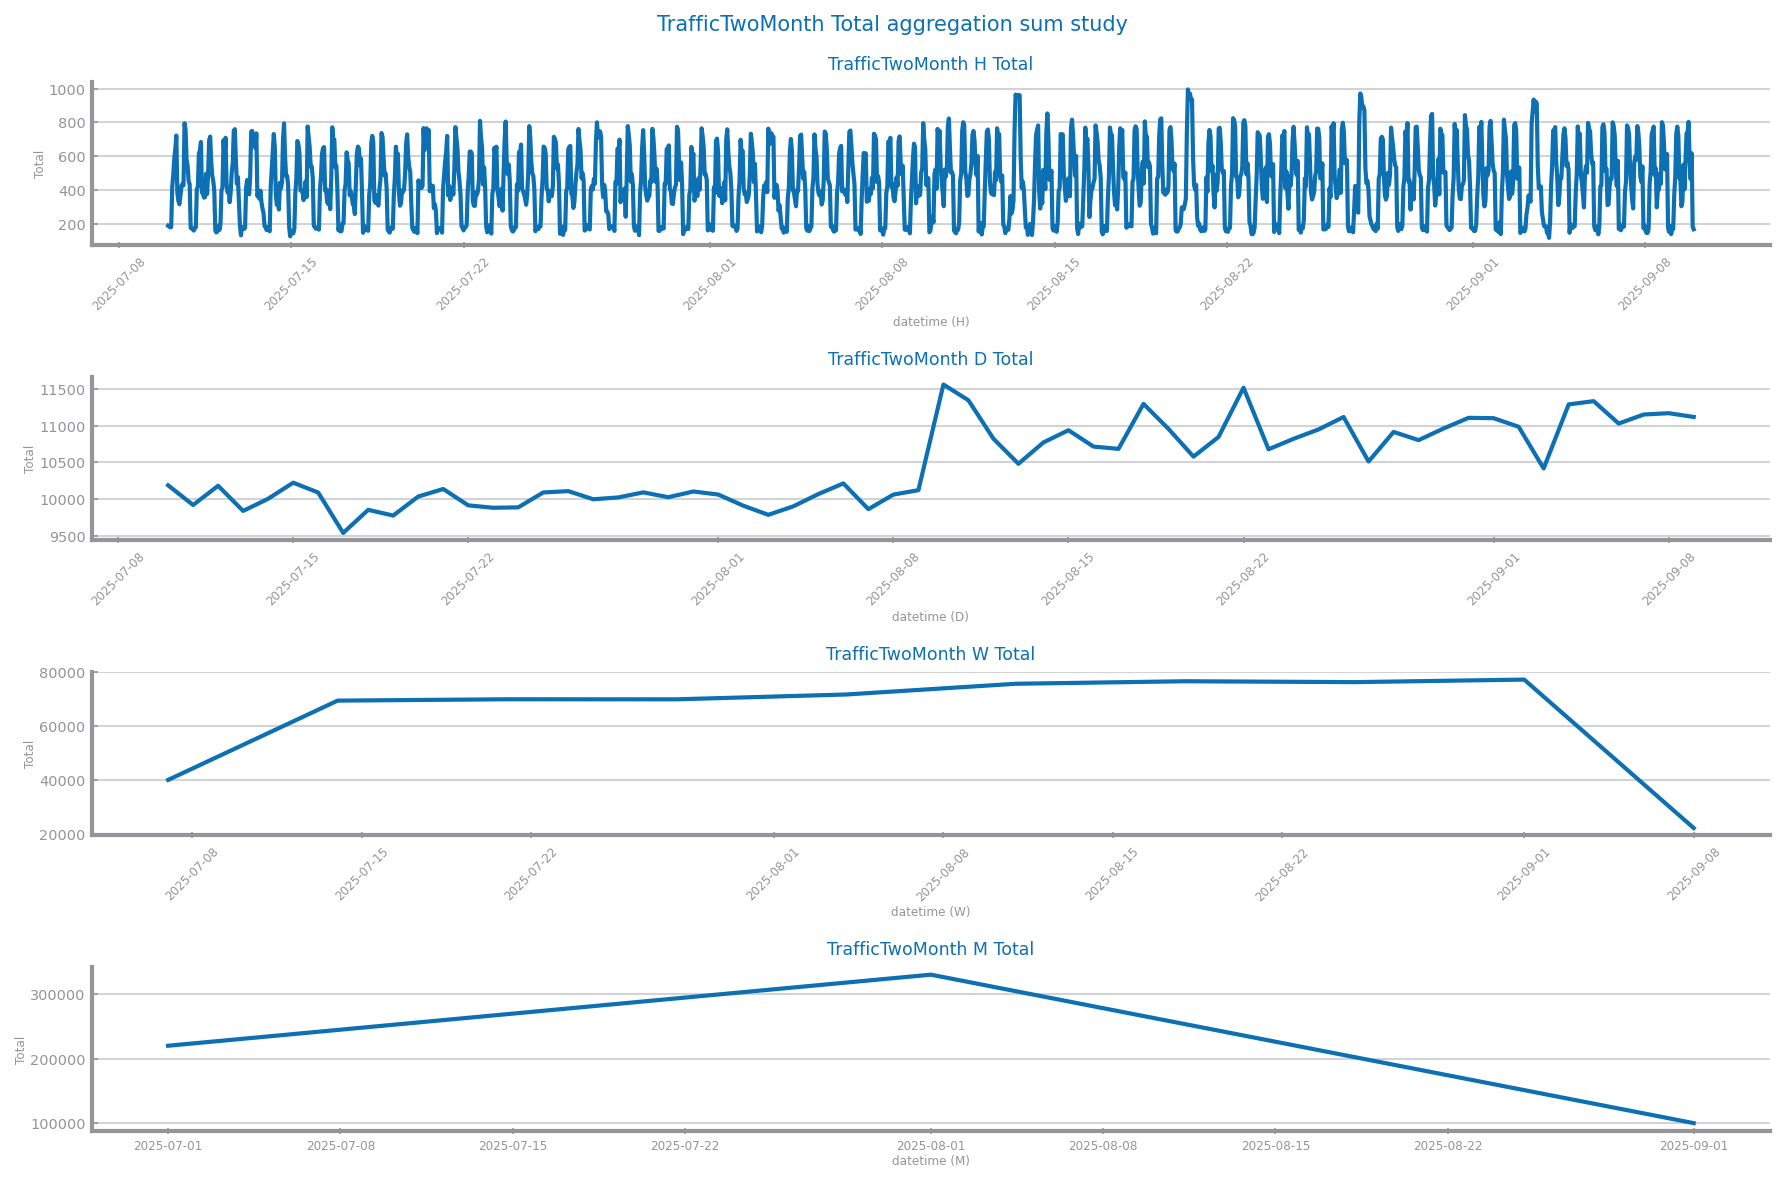

In [5]:
grans: list[str] = ["H", "D", "W", "M"]
fig: Figure
axs: list[Axes]
fig, axs = subplots(len(grans), 1, figsize=(3 * HEIGHT, HEIGHT / 2 * len(grans)))
fig.suptitle(f"{file_tag} {target} aggregation sum study")

for i in range(len(grans)):
    ss: Series = ts_aggregation_by(series, grans[i], agg_func=sum)
    plot_line_chart(
        ss.index.to_list(),
        ss.to_list(),
        ax=axs[i],
        xlabel=f"{ss.index.name} ({grans[i]})",
        ylabel=target,
        title=f"{file_tag} {grans[i]} {target}",
    )
tight_layout()
show()

#### 1.3.1\. 5-Number Summary

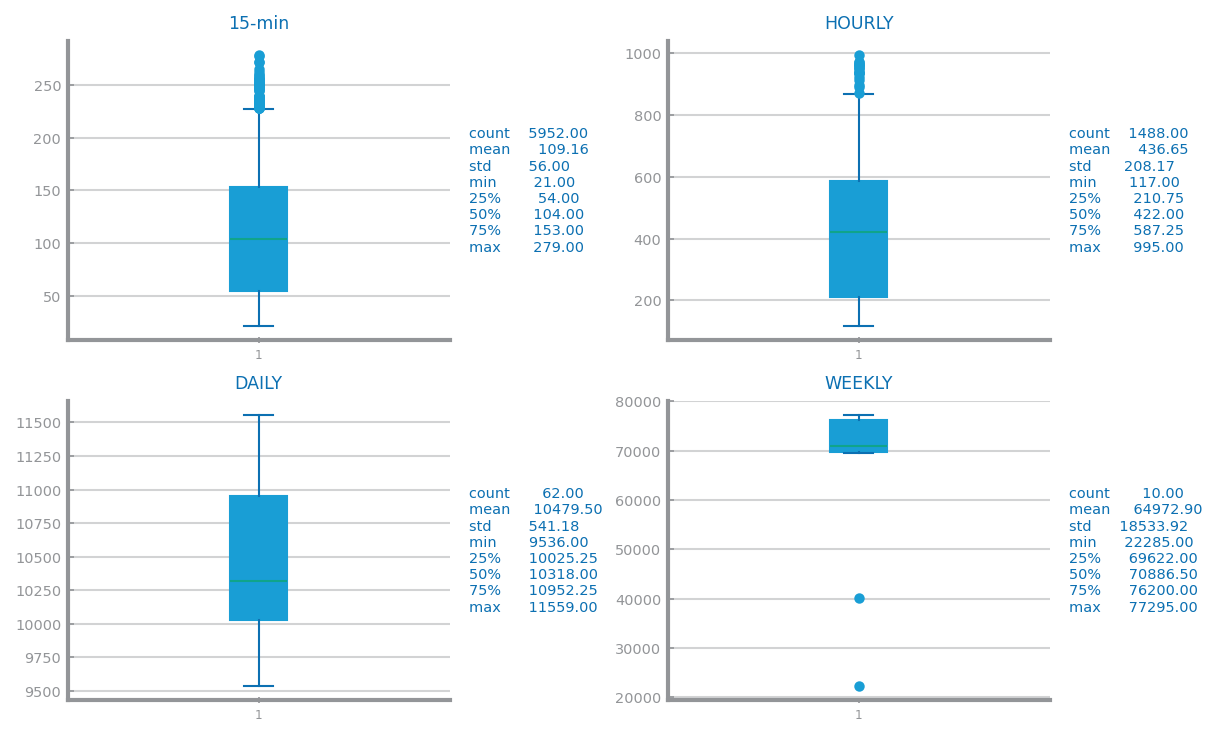

In [6]:
series: Series = data[target]
ss_hours: Series = ts_aggregation_by(series, gran_level="H", agg_func=sum)
ss_days: Series = ts_aggregation_by(series, gran_level="D", agg_func=sum)
ss_weeks: Series = ts_aggregation_by(series, gran_level="W", agg_func=sum)
ss_months: Series = ts_aggregation_by(series, gran_level="M", agg_func=sum)

fig, axs = subplots(2, 2, figsize=(2 * HEIGHT, 1.2*HEIGHT), constrained_layout=True)

# --- BOX PLOTS ---

set_chart_labels(axs[0, 0], title="15-min")
axs[0, 0].boxplot(series)

set_chart_labels(axs[0, 1], title="HOURLY")
axs[0, 1].boxplot(ss_hours)

set_chart_labels(axs[1, 0], title="DAILY")
axs[1, 0].boxplot(ss_days)

set_chart_labels(axs[1, 1], title="WEEKLY")
axs[1, 1].boxplot(ss_weeks)

# set_chart_labels(axs[1, 1], title="MONTHLY")
# axs[1, 1].boxplot(ss_months)

# --- STATS TEXT BESIDE EACH AXES ---
for ax, data in zip(
    axs.ravel(),
    [series, ss_hours, ss_days, ss_weeks]
):
    stats_str = data.describe().round(2).to_string()

    ax.text(
        1.05, 0.5,
        stats_str,
        transform=ax.transAxes,
        fontsize="x-small",
        va="center",
        ha="left",
    )

show()



#### 1.3.2\. Variables Distribution

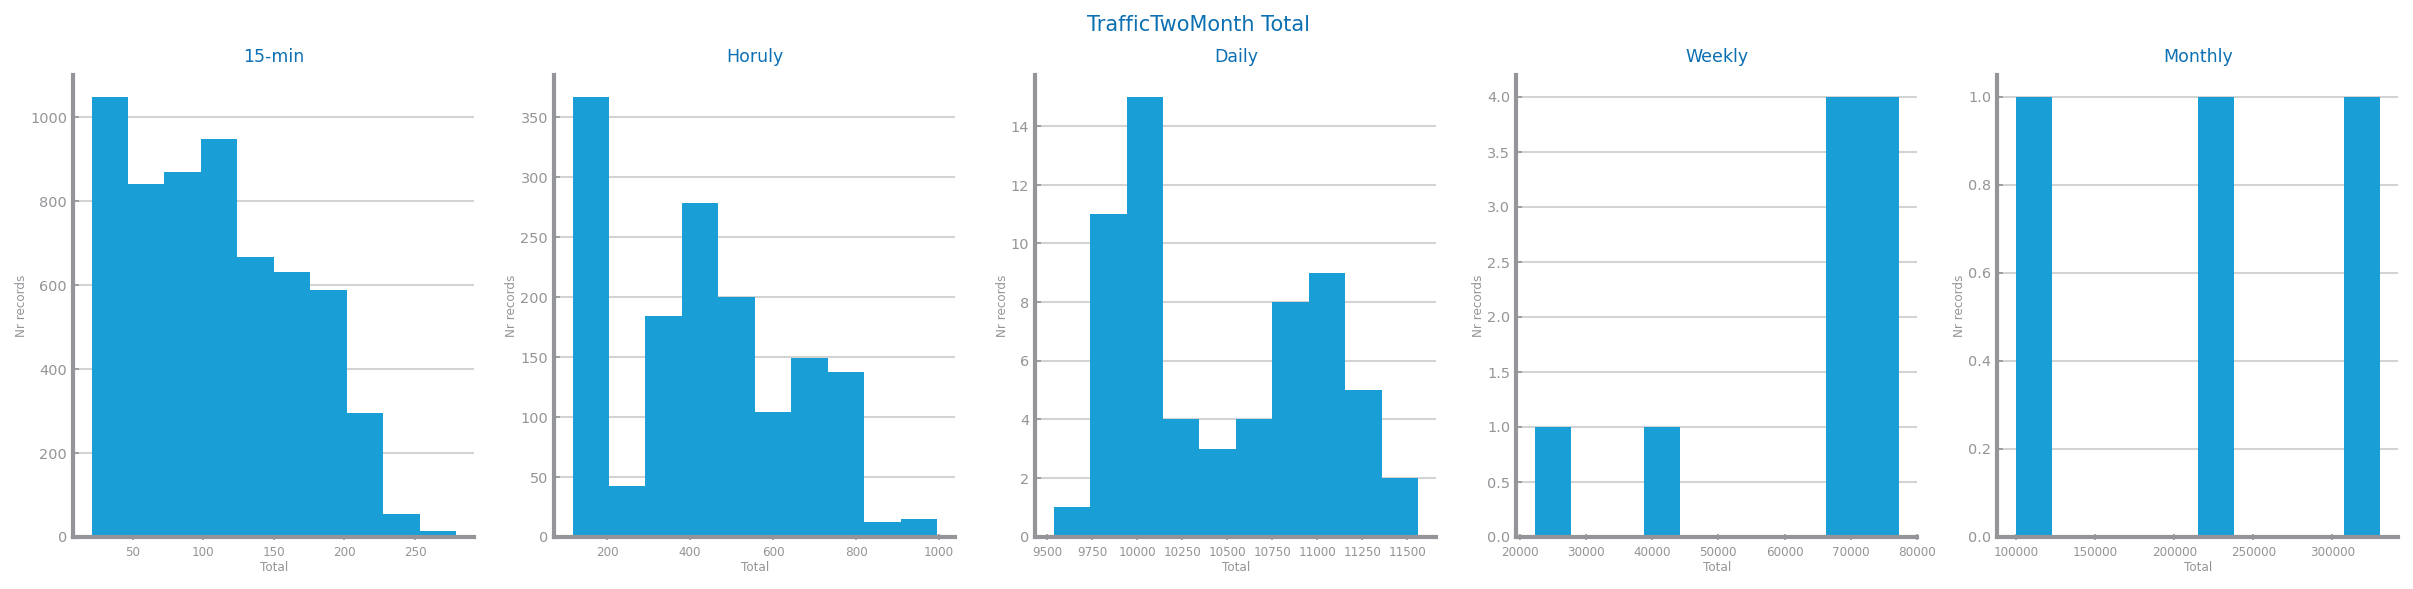

In [7]:
grans: list[Series] = [series, ss_hours, ss_days, ss_weeks, ss_months]
gran_names: list[str] = ["15-min", "Horuly", "Daily", "Weekly", "Monthly"]
fig: Figure
axs: array
fig, axs = subplots(1, len(grans), figsize=(len(grans) * HEIGHT, HEIGHT))
fig.suptitle(f"{file_tag} {target}")
for i in range(len(grans)):
    set_chart_labels(axs[i], title=f"{gran_names[i]}", xlabel=target, ylabel="Nr records")
    axs[i].hist(grans[i].values)
show()

#### 1.3.3\. Autocorrelation
Lags allow to compare past values with current values.
A lag of 1 means you shift the series one position down — each entry is replaced with the value that occurred one time-step earlier. A lag of 2 means the value from two time-steps earlier, and so on

<Axes: xlabel='datetime', ylabel='Total'>

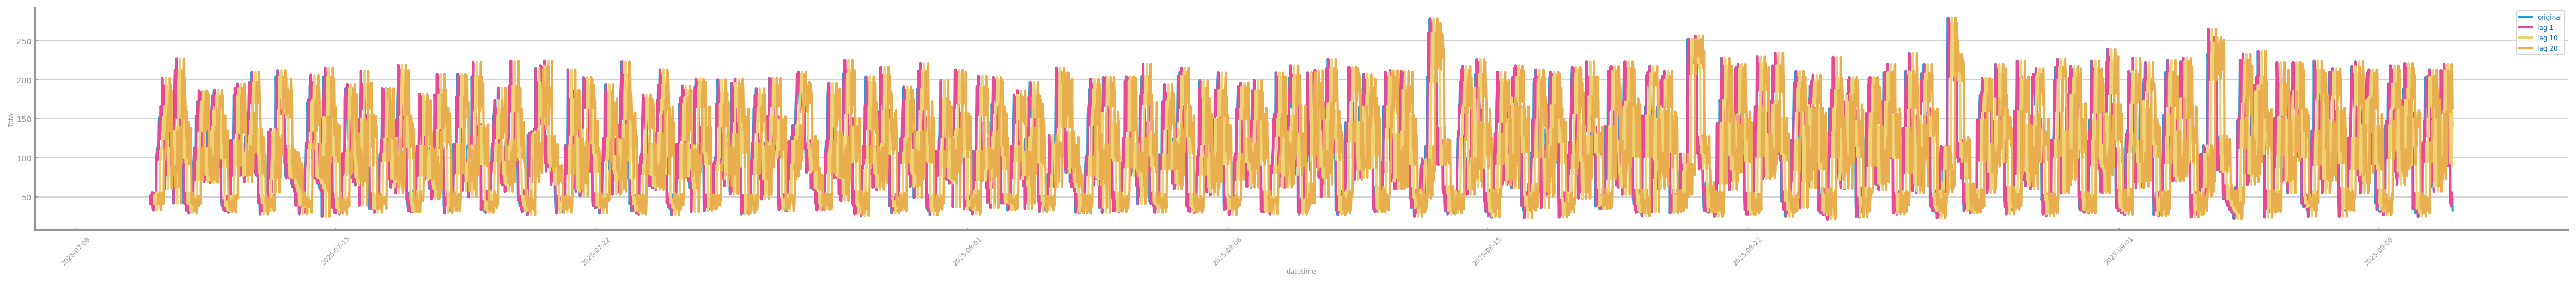

In [17]:
def get_lagged_series(series: Series, max_lag: int, delta: int = 1):
    lagged_series: dict = {"original": series, "lag 1": series.shift(1)}
    for i in range(delta, max_lag + 1, delta):
        lagged_series[f"lag {i}"] = series.shift(i)
    return lagged_series


figure(figsize=(10*HEIGHT, HEIGHT))
lags = get_lagged_series(series, 20, 10)
plot_multiline_chart(series.index.to_list(), lags, xlabel=index, ylabel=target)

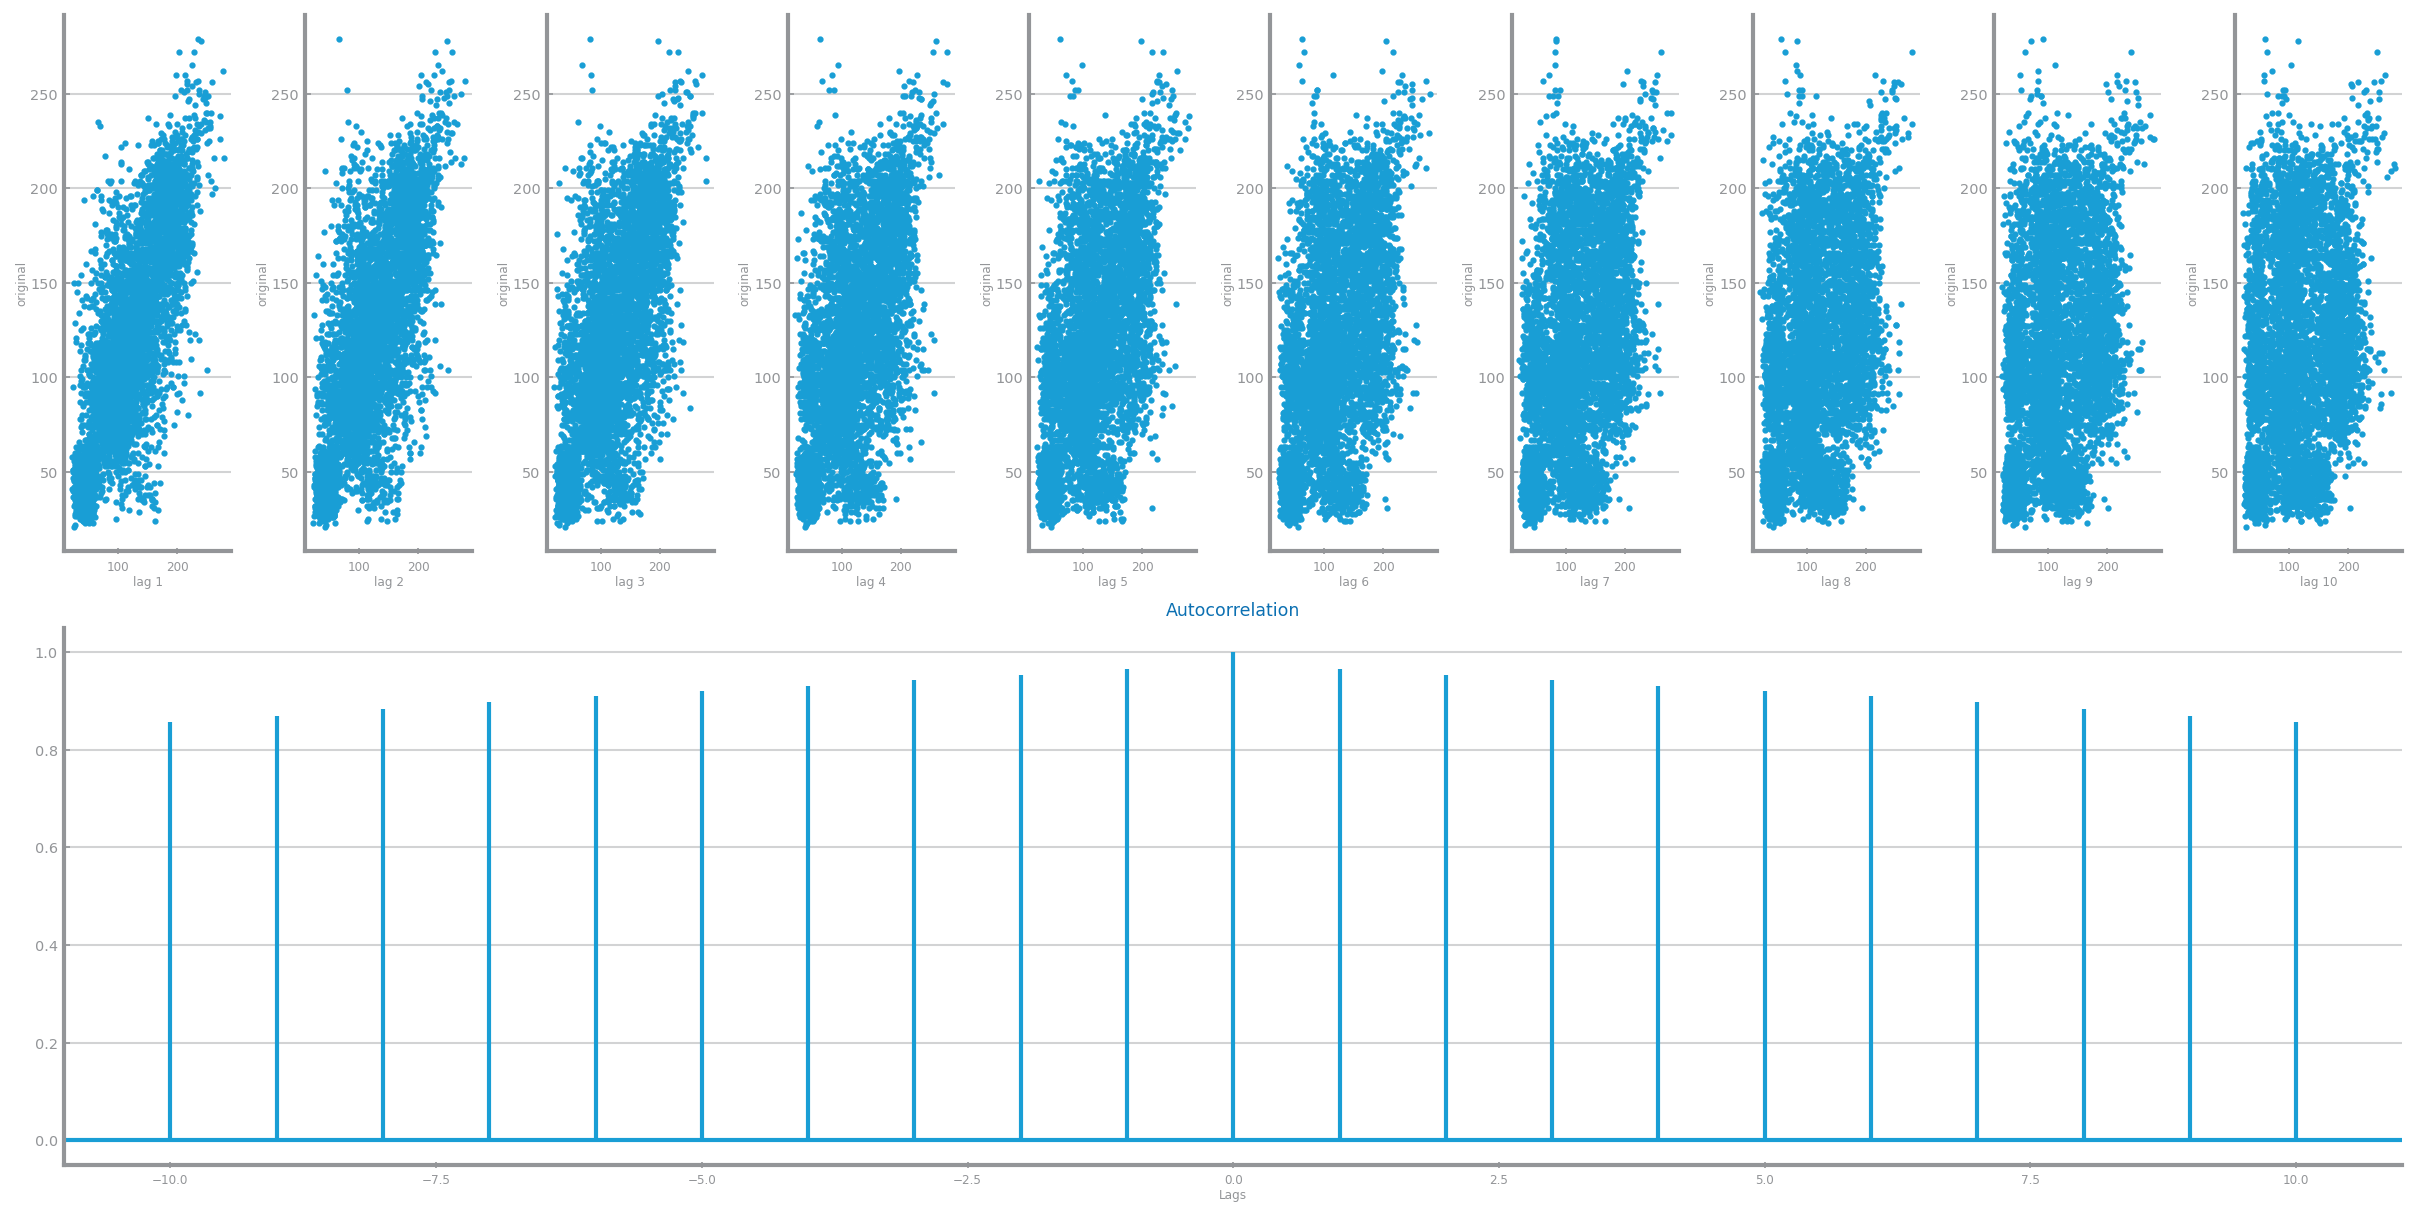

In [9]:
from matplotlib.pyplot import setp
from matplotlib.gridspec import GridSpec


def autocorrelation_study(series: Series, max_lag: int, delta: int = 1):
    k: int = int(max_lag / delta)
    fig = figure(figsize=(4 * HEIGHT, 2 * HEIGHT), constrained_layout=True)
    gs = GridSpec(2, k, figure=fig)

    series_values: list = series.tolist()
    for i in range(1, k + 1):
        ax = fig.add_subplot(gs[0, i - 1])
        lag = i * delta
        ax.scatter(series.shift(lag).tolist(), series_values)
        ax.set_xlabel(f"lag {lag}")
        ax.set_ylabel("original")
    ax = fig.add_subplot(gs[1, :])
    ax.acorr(series, maxlags=max_lag)
    ax.set_title("Autocorrelation")
    ax.set_xlabel("Lags")
    return


autocorrelation_study(series, 10, 1)

### 1.3\. Stationarity

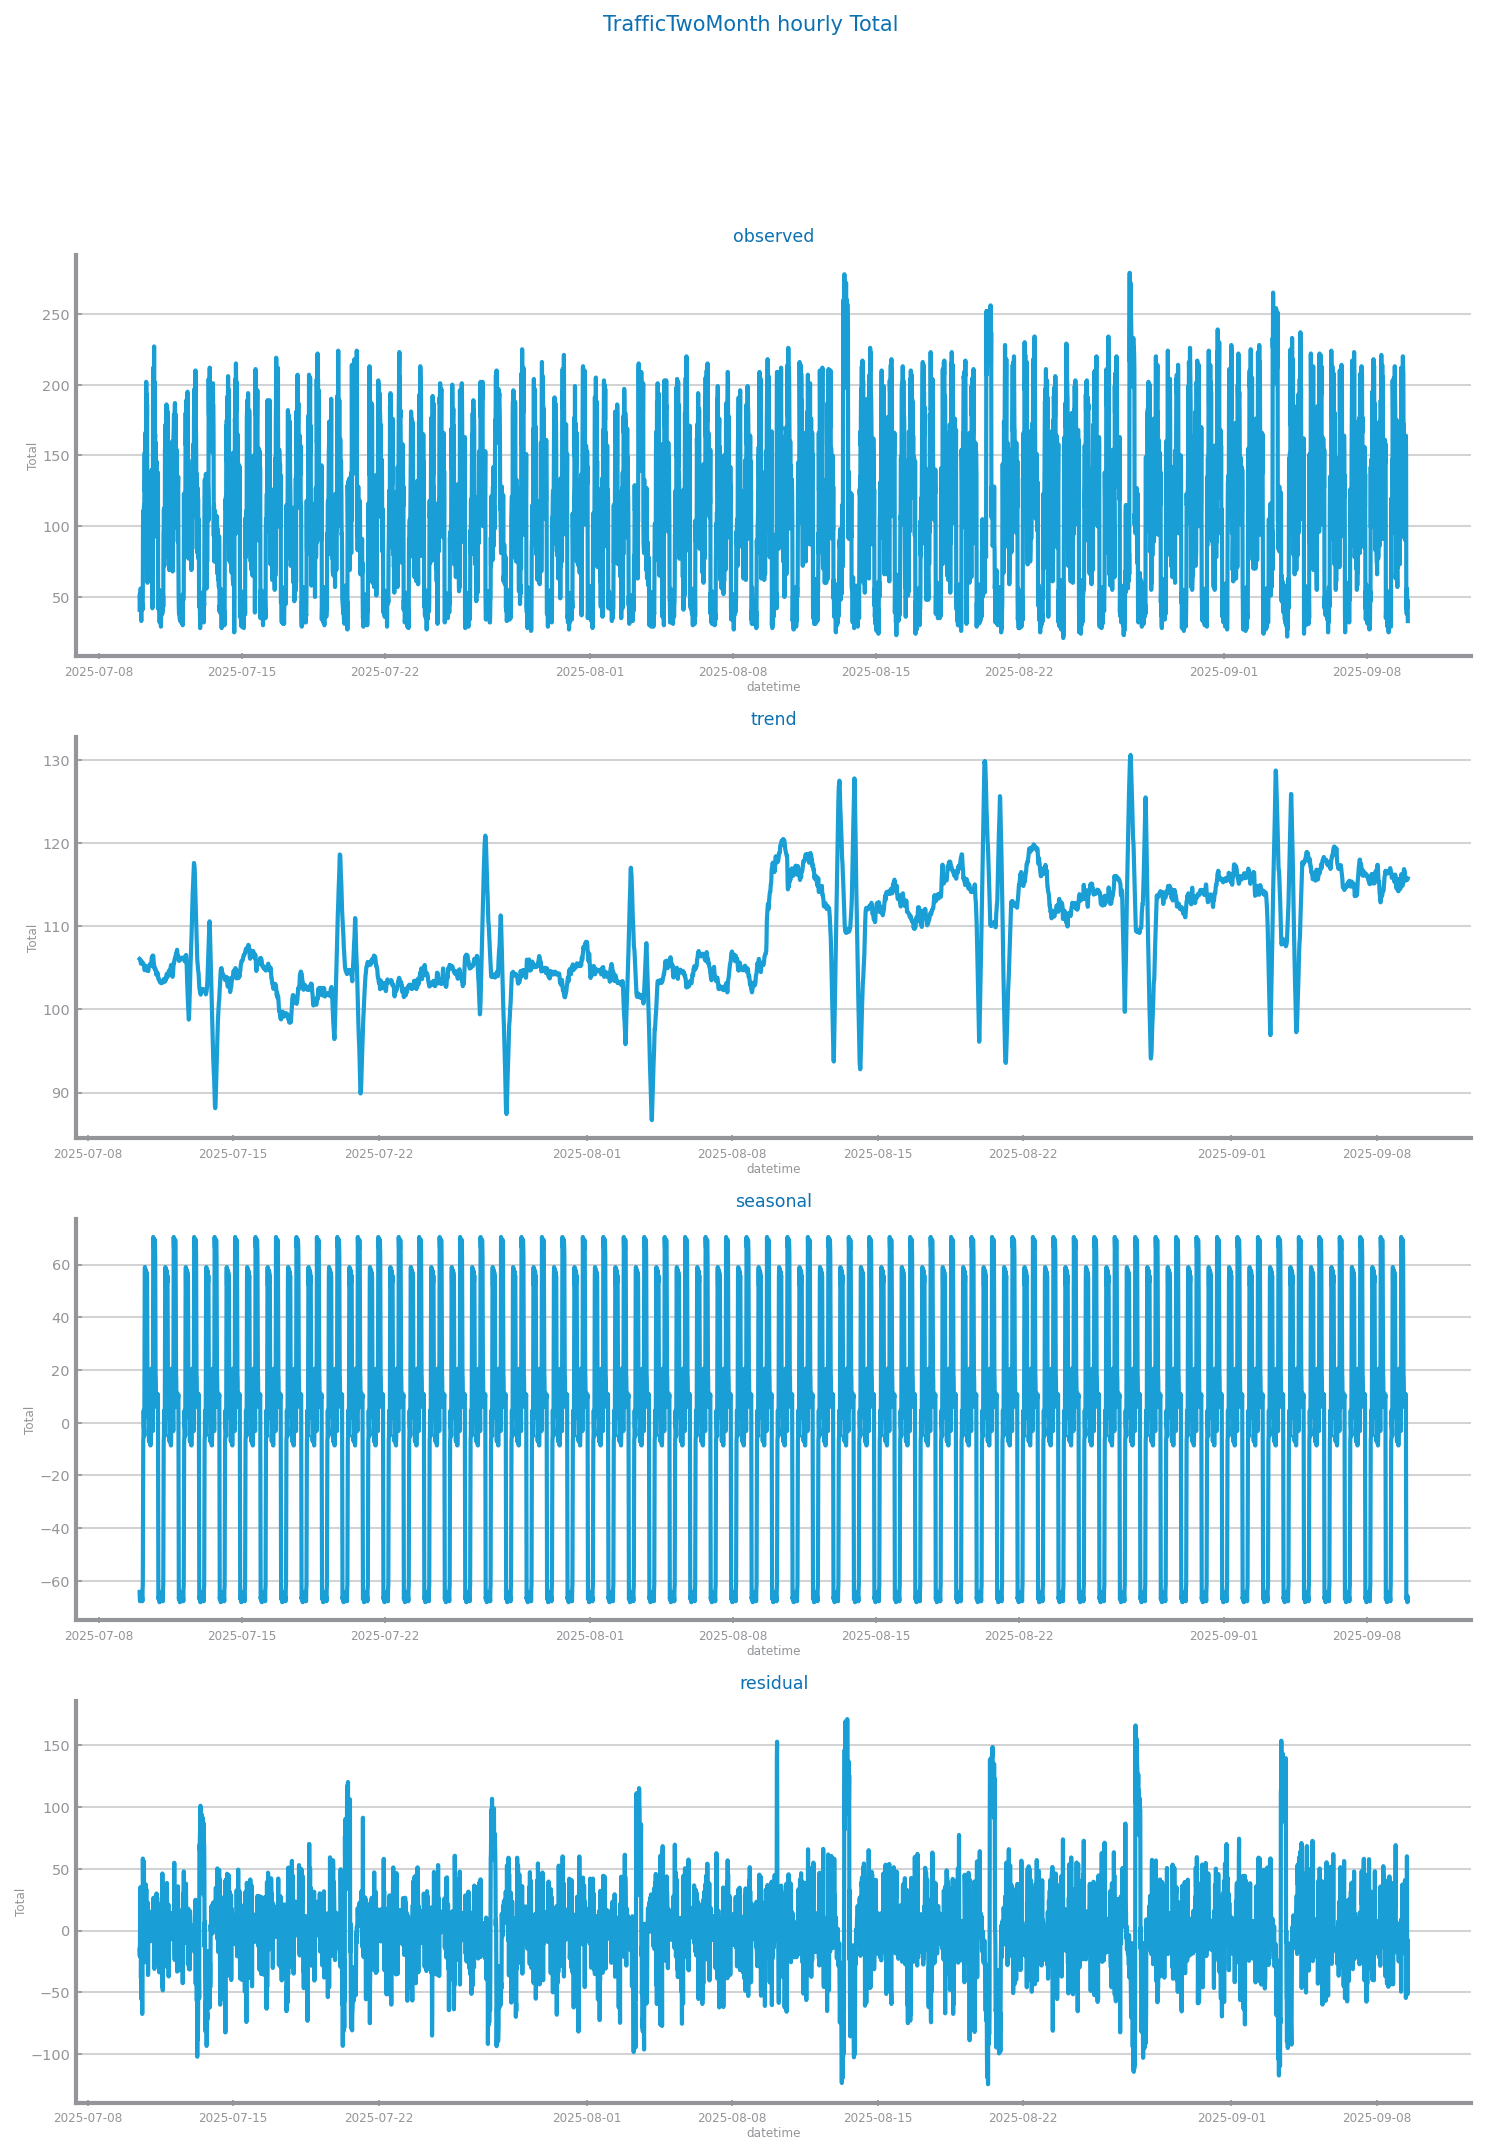

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Series
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.pyplot import subplots

def plot_components(
    series: Series,
    title: str = "",
    x_label: str = "time",
    y_label: str = "",
    period: int = 96,          # <--- for 15-min data: 96 points per day
) -> list[Axes]:
    # ensure regular 15-min frequency
    series = series.asfreq("15T")

    decomposition = seasonal_decompose(
        series,
        model="add",
        period=period          # <--- key change
    )

    components: dict = {
        "observed": series,
        "trend": decomposition.trend,
        "seasonal": decomposition.seasonal,
        "residual": decomposition.resid,
    }

    rows: int = len(components)
    fig: Figure
    axs: list[Axes]
    fig, axs = subplots(rows, 1, figsize=(3 * HEIGHT, rows * HEIGHT))
    fig.suptitle(f"{title}")

    for i, key in enumerate(components):
        set_chart_labels(axs[i], title=key, xlabel=x_label, ylabel=y_label)
        axs[i].plot(components[key])

    return axs

plot_components(
    series,
    title=f"{file_tag} 15-min {target}",
    x_label=series.index.name,
    y_label=target,
)
show()


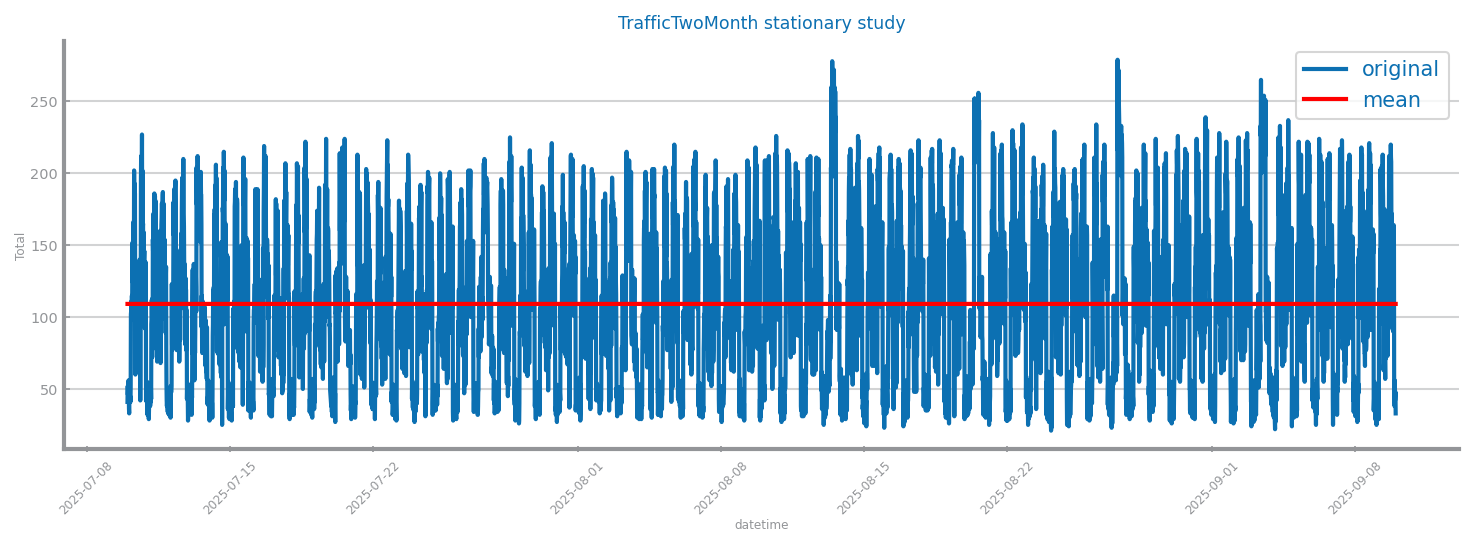

In [13]:
from matplotlib.pyplot import plot, legend

figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} stationary study",
    name="original",
)
n: int = len(series)
plot(series.index, [series.mean()] * n, "r-", label="mean")
legend()
show()

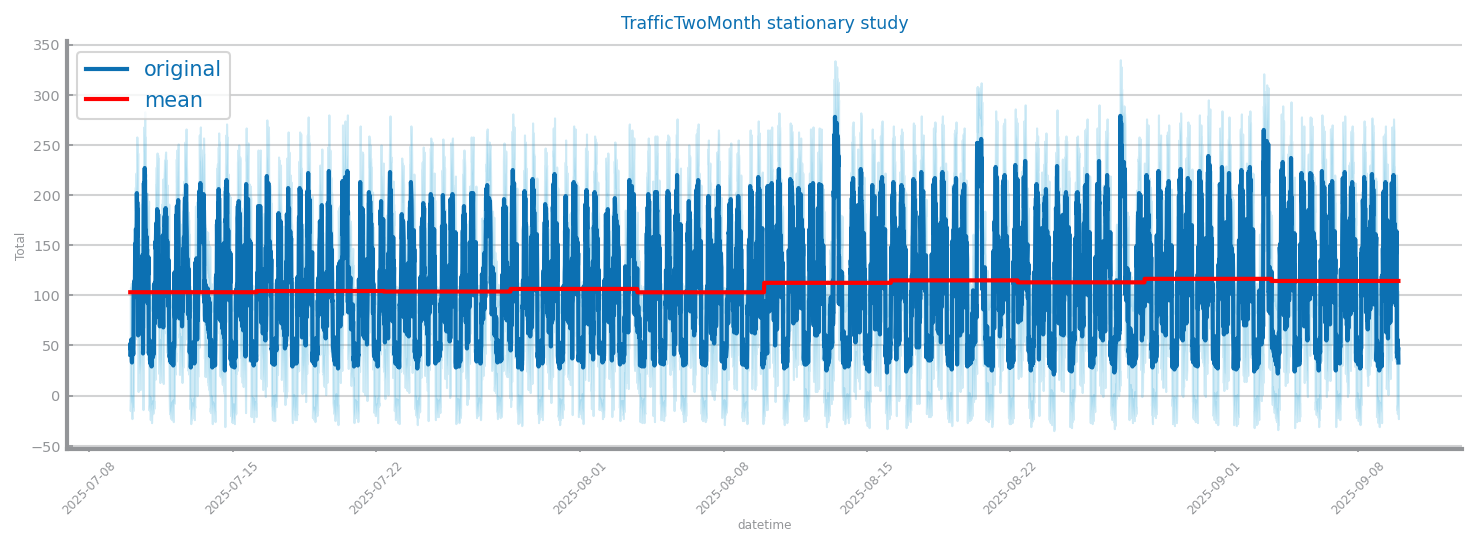

In [14]:
BINS = 10
mean_line: list[float] = []

for i in range(BINS):
    segment: Series = series[i * n // BINS : (i + 1) * n // BINS]
    mean_value: list[float] = [segment.mean()] * (n // BINS)
    mean_line += mean_value
mean_line += [mean_line[-1]] * (n - len(mean_line))

figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} stationary study",
    name="original",
    show_stdev=True,
)
n: int = len(series)
plot(series.index, mean_line, "r-", label="mean")
legend()
show()

#### 1.3.3\. Augmented Dickey-Fuller test
The **Augmented Dickey-Fuller test** is a statistical test widely used to verify the stationarity of a series. It determines how strongly a time series is defined by a trend: if this is true, then the series is non-stationary.
In this manner, we have two cases:
- **p-value <= 0.05** : the series is stationary, meaning its values do not depend on time;
- **p-value > 0.05** : the series is non-stationary, meaning it shows a time-dependent structure.


In [15]:
from statsmodels.tsa.stattools import adfuller

def eval_stationarity(series: Series) -> bool:
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.3f}")
    print(f"p-value: {result[1]:.3f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.3f}")
    return result[1] <= 0.05


print(f"The series {('is' if eval_stationarity(series) else 'is not')} stationary")

ADF Statistic: -14.441
p-value: 0.000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
The series is stationary
